[*********************100%***********************]  1 of 1 completed
Up trend
buy:2018-06-08 00:00:00 2779.030029296875
利確:2018-08-27 00:00:00 2896.739990234375
Up trend
buy:2018-08-28 00:00:00 2897.52001953125
損切り:2018-10-11 00:00:00 2728.3701171875
Up trend
buy:2019-02-22 00:00:00 2792.669921875
利確:2019-05-13 00:00:00 2811.8701171875
Up trend
buy:2019-06-20 00:00:00 2954.179931640625
利確:2019-09-09 00:00:00 2978.429931640625
Up trend
buy:2019-10-24 00:00:00 3010.2900390625
利確:2020-01-13 00:00:00 3288.1298828125
Up trend
buy:2020-01-15 00:00:00 3289.2900390625
損切り:2020-02-26 00:00:00 3116.389892578125
Up trend
buy:2020-06-01 00:00:00 3055.72998046875
利確:2020-08-20 00:00:00 3385.510009765625
Up trend
buy:2020-08-21 00:00:00 3397.159912109375
利確:2020-11-09 00:00:00 3550.5
Up trend
buy:2020-11-13 00:00:00 3585.14990234375
利確:2021-02-01 00:00:00 3773.860107421875
[4.235649118454532, -5.837747494532042, 0.6875211123987368, 0.8208707851634633, 9.229670235912813, -5.256457911314327, 10.792184

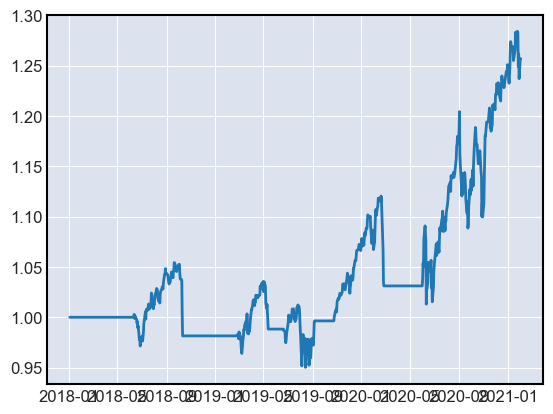

Axes(0.18,0.38;0.72x0.5)


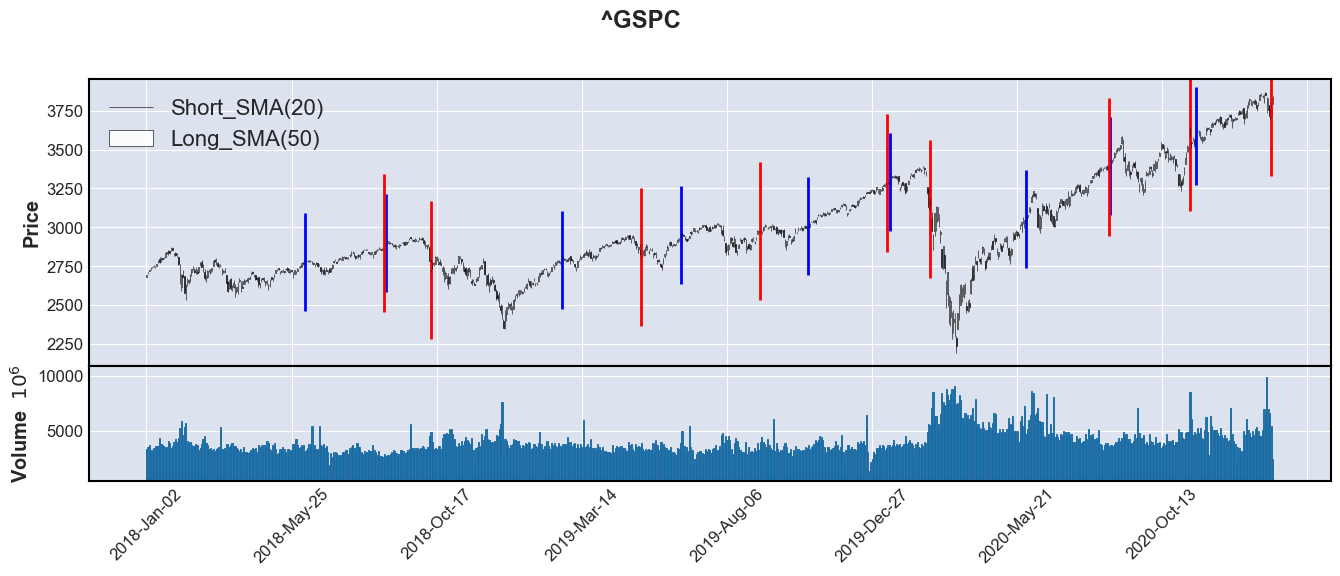

In [27]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpf

start = '2018-01-01'
end = dt.datetime.now()
stock_code = '^GSPC'
df = yf.download(stock_code, start, end, interval='1d')
# print(df.head(65))

# 何日間で最大最小の値を保持
shortTerm = 20
longTerm = 60

# 損切り率と利確の日数
stopLoss = 0.95
rikaku_day = 80

# judge U trend or Down trend by DC
buy_position = False # 1 means entered and 0 means not already entered
sell_position = False

# 買った（売った）後に経過した日数、損切りラインを保持
buy_dates = 0
sell_dates = 0
buy_stopLine = 0
sell_stopLine = 0
counter = 1
percentChange = []

# 資産、購入したときの資産
assets = [1]
buy_asset = 1

#　買った日、売った日
buy_days = []
sell_days = []

# chek the highest price in the past {term} times
df['Highest'+str(shortTerm)] = df.iloc[:, 4].rolling(window=shortTerm).max()
# chek the highest price in the past {term} times
df['Lowest'+str(shortTerm)] = df.iloc[:, 4].rolling(window=shortTerm).min()

# chek the highest price in the past {term} times
df['Highest'+str(longTerm)] = df.iloc[:, 4].rolling(window=longTerm).max()
# chek the highest price in the past {term} times
df['Lowest'+str(longTerm)] = df.iloc[:, 4].rolling(window=longTerm).min()


"""
メインループ
基本戦略
過去longTerm間の調整済み終値の最高値をその日の調整済み終値が更新したら購入or空売り
損切り率は5%。80日後に利確する。
最終日にまだ保持していた場合捌く
"""
# for i in range(1, len(df)):
for i in range(1,len(df)):
        
    shortHighest = df['Highest'+str(shortTerm)][i-1]
    shortLowest = df['Lowest'+str(shortTerm)][i-1]
    longHighest = df['Highest'+str(longTerm)][i-1]
    longLowest = df['Lowest'+str(longTerm)][i-1] 
    close = df['Adj Close'][i]
    sell_day = pd.to_datetime(df.index[i])
    
    if buy_position == False:
        assets.append(assets[i-1])
    else:
        assets.append(buy_asset*(close / buy_price))
        
    # avoid NaN data 
    # 買いトレンド
    if (np.isnan(longHighest)) == False:
        if (close > longHighest and buy_position == False):
            print('Up trend')
            buy_position = True
            buy_price = close
            buy_stopLine = close * stopLoss
            buy_asset = assets[i]
            buy_day = pd.to_datetime(df.index[i])
            buy_days.append(df.index[i])
            print('buy:'+str(df.index[i]),close)

    # 損切り
    if buy_position == True and close < buy_stopLine:
        buy_position = False
        percent = (close/buy_price - 1) * 100
        percentChange.append(percent)
        sell_days.append(df.index[i])
        print('損切り:'+str(df.index[i]),close)

    # 利確
    if  buy_position == True and (sell_day - buy_day).days > 79:
        buy_position = False
        percent = (close/buy_price - 1) * 100
        percentChange.append(percent)
        sell_days.append(df.index[i])
#         buy_dates = 0
        print('利確:'+str(df.index[i]),close)
#         print('Date:'+str(i),'Secure Profit Buy at the price {}'.format(close))
        
    # 損切りラインの更新
    # if buy_position = 

    #  最終日にまだ持ってたら利確する
    if (counter == df['Adj Close'].count() - 1):
        if buy_position == True:
            buy_position = False
            percent = (close / buy_price - 1) * 100
            percentChange.append(percent)
            buy_days.append(df.index[i])
#             buy_dates = 0
            print('最終日売:'+str(df.index[i]),close)
#             print('Date:'+str(i),'Last Day Buy at the price {}'.format(close))

#     # 買ってからの日数を更新する
#     if buy_position == True:
#         buy_dates += 1
    counter += 1



print(percentChange)

# statistic
gains = 0
numGains = 0
losses = 0
numLosses = 0
total_return = 1

for i in percentChange:
    if i > 0:
        numGains += 1
        gains += i
    else:
        numLosses += 1
        losses += i
    total_return = total_return * ((i / 100) + 1)

total_return = round((total_return - 1)*100, 2)

if numGains > 0:
    average_gain = gains / numGains
    max_return = max(percentChange)
else:
    average_gain = 0
    max_return = 'unknown'
    
if numLosses > 0:
    average_loss = losses / numLosses
    max_loss = min(percentChange)
    risk_reward_retio = - average_gain / average_loss
else:
    average_loss = 0
    max_loss = 'unknown'
    risk_reward_retio = 'inf'
    
if numGains > 0 or numLosses > 0:
    batting_ratio = numGains / (numGains + numLosses)
else:
    batting_ratio = 0
    
print('The period is from {} up to {}'.format(df.index[0], df.index[-1]))
print('Trades: {}'.format(numGains+numLosses))
print('Total return: {}%'.format(total_return))
print('Average Gain: {}'.format(average_gain))
print('Average Loss: {}'.format(average_loss))
print('Max Return: {}'.format(max_return))
print('Max Loss: {}'.format(max_loss))
print('Gain/Loss Ratio: {}'.format(risk_reward_retio))
print('Batting Average: {}'.format(batting_ratio))

# 資産の計算とドローダウンの計算
assets = np.array(assets)
max_asset = 1
max_drawdown = 0
for i in range(len(assets)):
    max_asset = max(max_asset,assets[i])
    now_drawdown = 1 - (assets[i]/max_asset)
    if now_drawdown < 0:
        continue
    max_drawdown = max(max_drawdown, now_drawdown)  
print(max_drawdown)
plt.plot(df.index,assets)
plt.show()

buy_signals = []
sell_signals = []

for i in df.index:
    if i in buy_days:
        buy_signals.append(df['Adj Close'][i])
    else:
        buy_signals.append(np.nan)
    if i in sell_days:
        sell_signals.append(df['Adj Close'][i])
    else:
        sell_signals.append(np.nan)
adp = [
    mpf.make_addplot(buy_signals,type='scatter',color='b',marker='|',markersize=5000),
    mpf.make_addplot(sell_signals,type='scatter',color='r',marker='|',markersize=10000)
]
fig, ax = mpf.plot(df,type='candle',figratio=(45,15),
                  addplot=adp, volume=True, title=str(stock_code), returnfig=True)
legend = ['Short_SMA(20)','Long_SMA(50)']
ax[0].legend(legend,fontsize=16)
print(ax[0])

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)
Buy at the price 2713.06005859375
Sell at the price 3826.31005859375
[41.03300243847261]
The period is from 2018-01-02 00:00:00 up to 2021-02-02 00:00:00
Trades: 1
Total return: 41.03%
Average Gain: 41.03300243847261
Average Loss: 0
Max Return: 41.03300243847261
Max Loss: unknown
Gain/Loss Ratio: inf
Batting Average: 1.0
0.3392496000265328


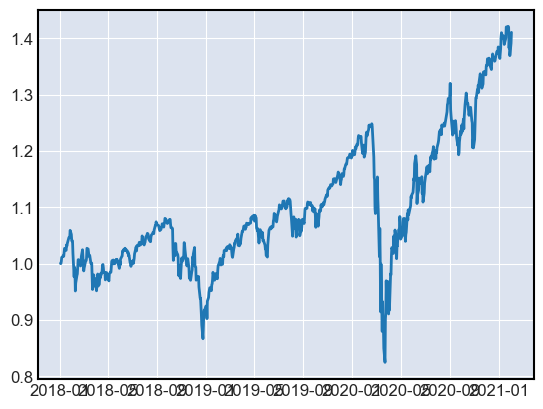

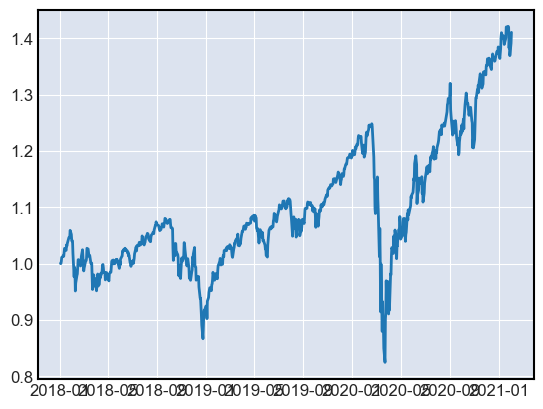

In [28]:
"""
メインループ
比較対象：最初の日に買って、最後の日に売る
"""

percentChange = []
counter = 1
print(df.index[:5])
assets = [1]

for i in range(1,len(df)):
#     print(counter)
#     print(counter,df.index[i])
#     print(buy_position, sell_position, buy_dates, sell_dates, buy_stopLine, sell_stopLine, 'Adj Close:{}'.format(df['Adj Close'][i]))
#     if counter == 100:
#         break
    close = df['Adj Close'][i]
    
    if i == 1:
        buy_price = close
        print('Buy at the price {}'.format(buy_price))
        
    if (counter == df['Adj Close'].count() - 1):
        percent = (close/buy_price - 1) * 100
        percentChange.append(percent)
        print('Sell at the price {}'.format(close))
    
    assets.append(1*(close/buy_price))
        
    counter += 1


print(percentChange)

# statistic
gains = 0
numGains = 0
losses = 0
numLosses = 0
total_return = 1

for i in percentChange:
    if i > 0:
        numGains += 1
        gains += i
    else:
        numLosses += 1
        losses += i
    total_return = total_return * ((i / 100) + 1)

total_return = round((total_return - 1)*100, 2)

if numGains > 0:
    average_gain = gains / numGains
    max_return = max(percentChange)
else:
    average_gain = 0
    max_return = 'unknown'
    
if numLosses > 0:
    average_loss = losses / numLosses
    max_loss = min(percentChange)
    risk_reward_retio = - average_gain / average_loss
else:
    average_loss = 0
    max_loss = 'unknown'
    risk_reward_retio = 'inf'
    
if numGains > 0 or numLosses > 0:
    batting_ratio = numGains / (numGains + numLosses)
else:
    batting_ratio = 0
    
print('The period is from {} up to {}'.format(df.index[0], df.index[-1]))
print('Trades: {}'.format(numGains+numLosses))
print('Total return: {}%'.format(total_return))
print('Average Gain: {}'.format(average_gain))
print('Average Loss: {}'.format(average_loss))
print('Max Return: {}'.format(max_return))
print('Max Loss: {}'.format(max_loss))
print('Gain/Loss Ratio: {}'.format(risk_reward_retio))
print('Batting Average: {}'.format(batting_ratio))

# 資産の計算とドローダウンの計算
assets = np.array(assets)
max_asset = 1
max_drawdown = 0
for i in range(len(assets)):
    max_asset = max(max_asset,assets[i])
    now_drawdown = 1 - (assets[i]/max_asset)
    if now_drawdown < 0:
        continue
    max_drawdown = max(max_drawdown, now_drawdown)  
print(max_drawdown)
# print(len(assets))
# print(assets.min())
# print('{}%'.format((round((1-assets.min())*100,2))))
plt.plot(df.index,assets)
plt.show()